<a href="https://colab.research.google.com/github/C23-PS237/TaniKami-Machine-Learning-MobileNet/blob/main/%5BMobileNet%5DPlant_Disease_Classification_TaniKami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download and extract dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
# ! pip install -q kaggle

In [ ]:
# ! mkdir ~/.kaggle

In [ ]:
# ! cp kaggle.json ~/.kaggle/

In [ ]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets list

In [ ]:
# !kaggle datasets download -d vipoooool/new-plant-diseases-dataset 

In [ ]:
!unzip -q /content/gdrive/MyDrive/new-plant-diseases-dataset.zip -d /content/

In [ ]:
# !kaggle datasets download -d nizorogbezuode/rice-leaf-images -d /content/gdrive/MyDrive

In [ ]:
!unzip -q /content/gdrive/MyDrive/rice-leaf-images.zip -d /content/

In [ ]:
# !rm /content/gdrive/MyDrive/Dataset3/rice-leaf-images.zip

In [ ]:
import numpy as np
import shutil
import os
import io
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import itertools
import os.path
from os import path
from datetime import datetime
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import sklearn.metrics

In [ ]:
# Check if the files are complete
root_dir = "/content/rice_images"
train_file_list = os.listdir(root_dir)
num_samples = 0
for folder in train_file_list :
  dir = root_dir + "/" + folder
  dir_list = os.listdir(dir)
  num_samples += len(dir_list)
print(f"number of rice samples is : {num_samples}")

root_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
train_file_list = os.listdir(root_dir)
num_samples = 0
for folder in train_file_list :
  dir = root_dir + "/" + folder
  dir_list = os.listdir(dir)
  num_samples += len(dir_list)
print(f"number of train plant samples is : {num_samples}")

root_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"
train_file_list = os.listdir(root_dir)
num_samples = 0
for folder in train_file_list :
  dir = root_dir + "/" + folder
  dir_list = os.listdir(dir)
  num_samples += len(dir_list)
print(f"number of val plant samples is : {num_samples}")

root_dir = "/content/test"
train_file_list = os.listdir(root_dir)
num_samples = 0
for folder in train_file_list :
  dir = root_dir + "/" + folder
  dir_list = os.listdir(dir)
  num_samples += len(dir_list)
print(f"number of test plant samples is : {num_samples}")

number of rice samples is : 3355
number of train plant samples is : 70295
number of val plant samples is : 17572
number of test plant samples is : 33


## Combining rice leaf dataset to the plant disease dataset

In [ ]:
# count the numbers of files in each rice folder 
rice_dir = '/content/rice_images'
rice_class = os.listdir(rice_dir) # list of class
rice_class_dir = []
for folder in rice_class:
  dir = rice_dir + '/' + folder
  rice_class_dir.append(dir) # list of class dir

num_class_rice =[]
for directory in rice_class_dir:
  listdir =  os.listdir(directory)
  num_class_rice.append(len(listdir)) # number of files in each class

In [ ]:
# Making a list of list , where each element is a list containing dir of files from a class
files_of_classes = []
for dir in rice_class_dir:
  files_in_dir = os.listdir(dir)
  full_paths =  [os.path.join(dir,file) for file in files_in_dir]
  files_of_classes.append(full_paths)

In [ ]:
# Make slices of each class for training, validation (testing set will be sliced by ImageDataGenerator)set
train_slice =[]
val_slice = []
test_slice = []
for folder in files_of_classes:
  num_train = int(len(folder)*0.7)
  # num_val = int(len(folder)*0.3) + num_train
  tr_slice = folder[:num_train]
  # vl_slice = folder[num_train:num_val]
  vl_slice = folder[num_train:]
  train_slice.append(tr_slice)
  val_slice.append(vl_slice)
  # test_slice.append(tst_slice)


In [ ]:
# Make the class names as new folders in our original train,val and test set
train_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"
val_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"
for name in rice_class:
  new_train_dir = train_dir + "Rice_" + name
  new_val_dir = val_dir + "Rice_" + name
  os.mkdir(new_train_dir)
  os.mkdir(new_val_dir)

In [ ]:
# Move the sliced files to their corresponding folders  

for train_folder in train_slice:
  for files in train_folder:
    folder_name = files.split("/")[3] 
    destination_folder = train_dir + "Rice_" + folder_name + "/"
    shutil.move(files, destination_folder)

for val_folder in val_slice:
  for files in val_folder:
    folder_name = files.split("/")[3] 
    destination_folder = val_dir + "Rice_" + folder_name + "/"
    shutil.move(files, destination_folder)

## Preprocessing data

In [ ]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)
batch_size = 32
epochs = 25

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                             shear_range=0.2,
                                                             zoom_range=0.2,
                                                             width_shift_range=0.2,
                                                             height_shift_range=0.2,
                                                             fill_mode="nearest")
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                           validation_split = 0.2) 

In [ ]:
train_data = train_datagen.flow_from_directory(train_dir, 
                                               target_size=target_size,
                                               batch_size=batch_size,
                                               shuffle =True,
                                               class_mode = "categorical"
                                               )
val_data = val_datagen.flow_from_directory(val_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = batch_size,
                                             shuffle = False,
                                             class_mode = "categorical",
                                             subset = "training")

test_data = val_datagen.flow_from_directory(val_dir,
                                             target_size = (image_size, image_size),
                                             batch_size = batch_size,
                                             shuffle = False,
                                             class_mode = "categorical",
                                             subset = "validation")

Found 72642 images belonging to 42 classes.
Found 14877 images belonging to 42 classes.
Found 3703 images belonging to 42 classes.


In [ ]:
categories = list(train_data.class_indices.keys())
print(train_data.class_indices)
print(categories)

{'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Blueberry___healthy': 4, 'Cherry_(including_sour)___Powdery_mildew': 5, 'Cherry_(including_sour)___healthy': 6, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7, 'Corn_(maize)___Common_rust_': 8, 'Corn_(maize)___Northern_Leaf_Blight': 9, 'Corn_(maize)___healthy': 10, 'Grape___Black_rot': 11, 'Grape___Esca_(Black_Measles)': 12, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13, 'Grape___healthy': 14, 'Orange___Haunglongbing_(Citrus_greening)': 15, 'Peach___Bacterial_spot': 16, 'Peach___healthy': 17, 'Pepper,_bell___Bacterial_spot': 18, 'Pepper,_bell___healthy': 19, 'Potato___Early_blight': 20, 'Potato___Late_blight': 21, 'Potato___healthy': 22, 'Raspberry___healthy': 23, 'Rice__BrownSpot': 24, 'Rice__Healthy': 25, 'Rice__Hispa': 26, 'Rice__LeafBlast': 27, 'Soybean___healthy': 28, 'Squash___Powdery_mildew': 29, 'Strawberry___Leaf_scorch': 30, 'Strawberry___healthy': 31, 'Tomato__

In [ ]:
import json
with open('class_indices.json','w') as f:
  json.dump(train_data.class_indices, f)

## Import MobileNet, change top layers, training

In [ ]:
base_model =  tf.keras.applications.MobileNet(weights="imagenet",
                                              include_top= False,
                                              input_shape = input_shape)
base_model.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
inputs = keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(len(categories), activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=x, name="LeafDisease_MobileNet")

In [ ]:
optimizer =  keras.optimizers.Adam()
model.compile(optimizer=optimizer, 
              loss = keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy(),'accuracy'])

In [ ]:
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=epochs,
                    steps_per_epoch=150,
                    validation_steps=100,
                   )

Epoch 1/25
150/150 [==============================] - 291s 2s/step - loss: 0.2180 - categorical_accuracy: 0.9246 - accuracy: 0.9246 - val_loss: 0.0768 - val_categorical_accuracy: 0.9775 - val_accuracy: 0.9775
Epoch 2/25
150/150 [==============================] - 261s 2s/step - loss: 0.2485 - categorical_accuracy: 0.9121 - accuracy: 0.9121 - val_loss: 0.1086 - val_categorical_accuracy: 0.9650 - val_accuracy: 0.9650
Epoch 3/25
150/150 [==============================] - 261s 2s/step - loss: 0.2401 - categorical_accuracy: 0.9194 - accuracy: 0.9194 - val_loss: 0.0942 - val_categorical_accuracy: 0.9706 - val_accuracy: 0.9706
Epoch 4/25
150/150 [==============================] - 311s 2s/step - loss: 0.2192 - categorical_accuracy: 0.9254 - accuracy: 0.9254 - val_loss: 0.0990 - val_categorical_accuracy: 0.9684 - val_accuracy: 0.9684
Epoch 5/25
150/150 [==============================] - 315s 2s/step - loss: 0.2505 - categorical_accuracy: 0.9144 - accuracy: 0.9144 - val_loss: 0.0828 - val_categor

## Plot metrics

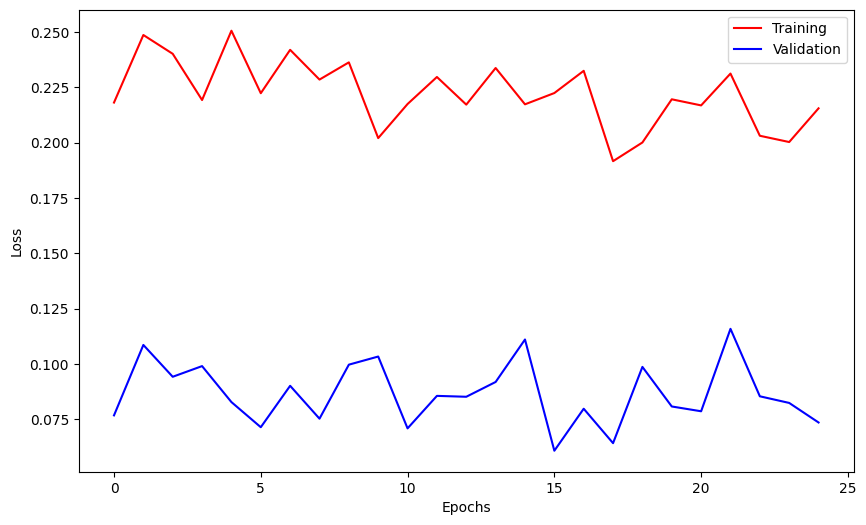

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(10,6))
plt.plot(epochs, loss, c="red", label="Training")
plt.plot(epochs, val_loss, c="blue", label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

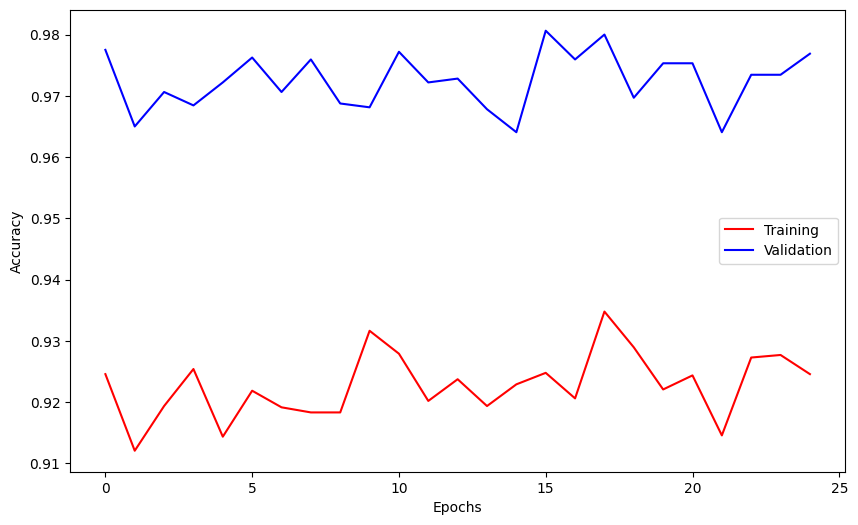

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs, acc, c="red", label="Training")
plt.plot(epochs, val_acc, c="blue", label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
# Calculate the accuracy of the test dataset
predictions = model.predict(test_data)
predicted_class = np.argmax(predictions, axis=1)
ground_truth = test_data.classes
accuracy = accuracy_score(ground_truth, predicted_class)

116/116 [==============================] - 109s 935ms/step


In [ ]:
print(f"the test accuracy is {accuracy}")

the test accuracy is 0.9330272751822847


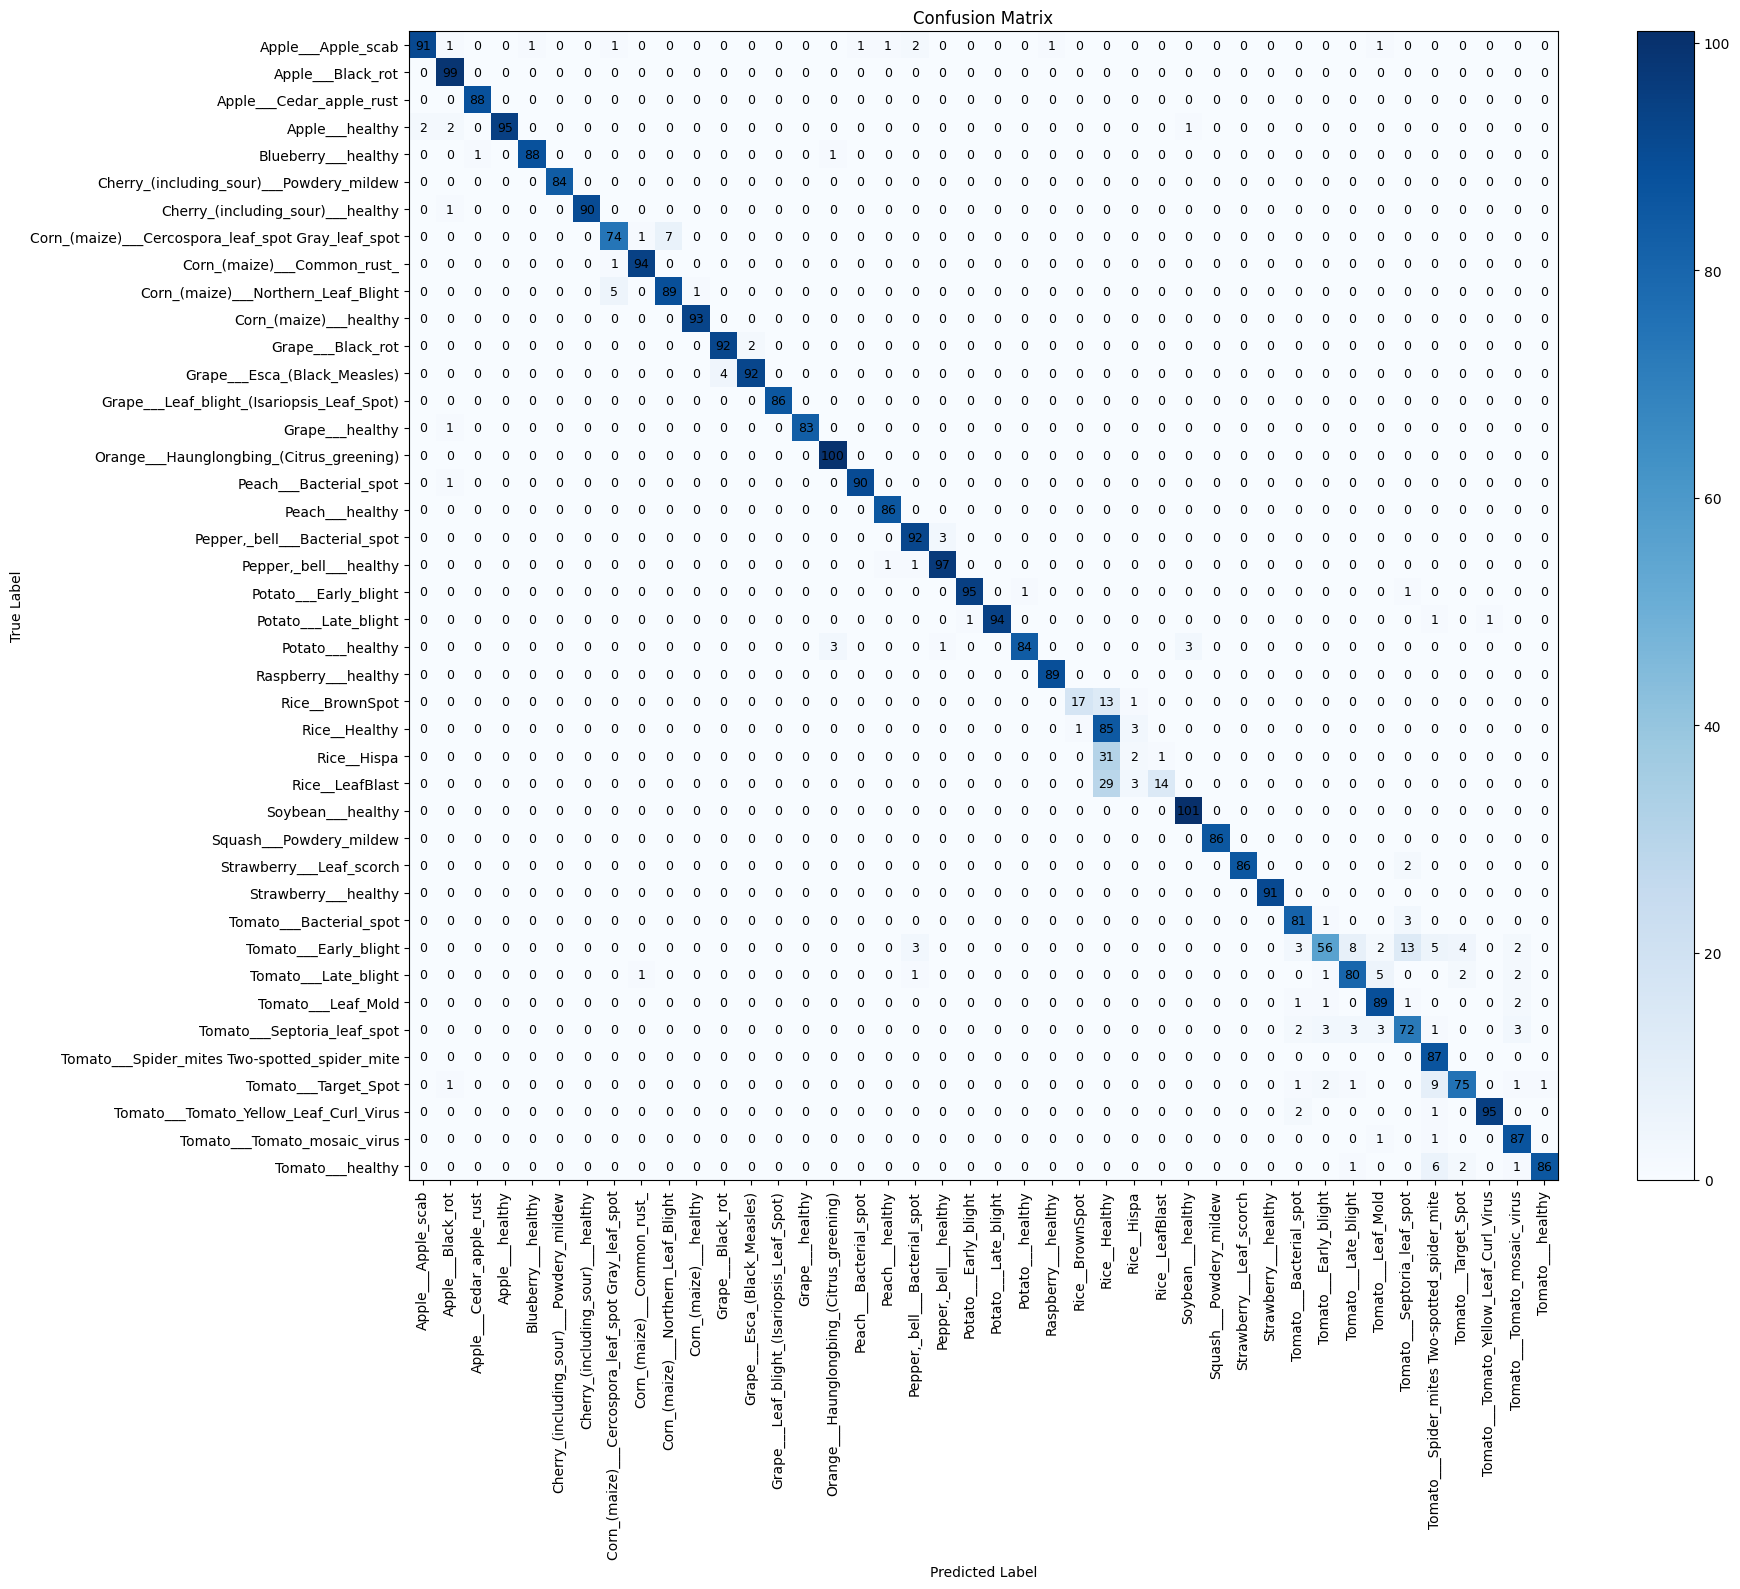

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Example ground truth and predicted labels (replace with your own data)
ground_truth = ground_truth
predicted_labels = predicted_class

# Define the class labels (replace with your own class labels)
class_labels = categories

# Generate confusion matrix
confusion_mat = confusion_matrix(ground_truth, predicted_labels)

# Set figure size
plt.figure(figsize=(20, 16))

# Plot confusion matrix
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=90)
plt.yticks(tick_marks, class_labels)

# Add labels to each cell
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        plt.text(j, i, confusion_mat[i, j], ha='center', va='center', fontsize=9)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.tight_layout()  # Adjust the spacing
plt.show()


## Upload image to predict

In [ ]:
from tensorflow.keras.utils import load_img, img_to_array
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = load_img(path, target_size=target_size)
  x = img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  three_max_class = np.argsort(classes)[0][-3:]
  ranks = ['third', 'second', 'most']
  for index in reversed(range(3)):
    probability = classes[0][three_max_class[index]]*100
    print(f"The {ranks[index]} likely class: {categories[three_max_class[index]]}")
    print(f"With the probability of : {probability:.2f}%")

#print(fn)
print(three_max_class)
print(classes)

Saving TomatoYellowCurlVirus3 (1).JPG to TomatoYellowCurlVirus3 (1).JPG
1/1 [==============================] - 0s 44ms/step
The most likely class: Apple___Apple_scab
With the probability of : 40.19%
The second likely class: Corn_(maize)___healthy
With the probability of : 28.12%
The third likely class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
With the probability of : 17.44%
[ 7 10  0]
[[4.01850462e-01 2.75066420e-02 6.56629636e-05 2.43325376e-05
  9.08741185e-06 4.96311543e-08 4.81303175e-08 1.74435303e-01
  7.02324323e-05 7.45534152e-03 2.81223595e-01 5.64903894e-06
  1.01176465e-06 2.01101488e-04 4.01450905e-07 4.25789915e-02
  5.52512176e-07 9.93853444e-09 1.18770615e-04 1.46479792e-07
  1.47236570e-08 8.67924030e-07 2.42167513e-08 4.71824890e-09
  1.10133364e-07 1.03915987e-07 1.17659745e-07 1.59134288e-04
  1.34806244e-09 9.74507057e-05 2.54663290e-04 8.65619440e-05
  4.55972577e-06 9.64511287e-07 7.00400909e-04 5.88654950e-02
  2.97019426e-07 2.12802065e-09 3.28318691e

## Save model and convert to tflite

In [ ]:
!mkdir savedModel
export_dir = 'savedModel/1'
tf.saved_model.save(model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
import pathlib
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

12978396